# Práctica 3: Aprendizaje automático supervisado

El objetivo de esta práctica es aplicar los distintos algoritmos de aprendizaje automático disponibles en la scikit-learn [sklearn](https://scikit-learn.org/stable/) sobre un conjuntos de datos y aprender a interpretar los resultados obtenidos.

Lo más importante en esta práctica no es el código Python, sino el análisis de los datos y modelos que construyas y las explicaciones razonadas de cada una de las decisiones que tomes. __No se valorarán trozos de código o gráficas sin ningún tipo de contexto o explicación__.

Finalmente, recuerda establecer el parámetro `random_state` en todas las funciones que tomen decisiones aleatorias para que los resultados sean reproducibles (los resultados no varíen entre ejecuciones).

__Número de grupo: J__

__Nombres de los estudiantes: Pablo Navarro Cebrián y Adrián Gómez Lamuedra__

# Apartado 2: Clasificación

## 1) Carga del conjunto de datos

---



En este notebook trabajaremos con un conjunto de datos con diferentes características médicas de personas. El objetivo es establecer un diagnóstico sobre si tiene una enfermedad cardiovacular o no.

Crea un dataframe a partir del fichero `heart_failure.csv` que se proporciona junto con la práctica. Antes de nada, elimina las filas con valores nulos.



In [ ]:
import pandas as pd
import numpy as np
from sklearn import datasets
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.utils.multiclass import unique_labels
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
# Función extraída de
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


Cargamos el dataset sobre df, eliminando las filas con colesterol = 0, que es un caso biológicamente imposible.

In [ ]:
RANDOM_STATE = 333

df = pd.read_csv('heart_failure.csv')
df = df.dropna()
df = df[df['Cholesterol'] > 0].copy()
df = df.reset_index(drop=True).copy()
df

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
741,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
742,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1
743,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
744,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1


## 2) Análisis de los datos

Comprueba si las clases a predecir están equilibradas y explica cómo afecta tener o no clases equilibradas a la hora de entrenar y evaluar un modelo.

In [ ]:
df["HeartDisease"].value_counts()

HeartDisease
0    390
1    356
Name: count, dtype: int64

In [ ]:
df["HeartDisease"].value_counts() / df["HeartDisease"].count() * 100

HeartDisease
0    52.27882
1    47.72118
Name: count, dtype: float64

Observamos que las clases están bastante equilibradas. Aunque sea un predictor de enfermedades, el porcentaje de gente enferma y no enferma en el conjunto de datos es parecido, por lo que deducimos que el estudio está realizado sobre gente propensa a tener enfermedades cardiovasculares. Dado que las clases están bastante equilibradas, consideramos que la tasa de aciertos será una medida apropiada para evaluar nuestro predictor. A pesar de ello, también es conveniente utilizar más medidas como la precisión, la exhaustividad y la F1.

### 2.1) Numéricos

Analiza razonadamente las distribuciones de cada una de las variables numéricas (medias, desviaciones típicas, rangos, ...) y las principales relaciones entre pares de variables (diagrama de dispersión, coeficientes de correlación, ...).

In [ ]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Age,746.0,52.882038,9.505888,28.0,46.00,54.0,59.0,77.0
RestingBP,746.0,133.022788,17.282750,92.0,120.00,130.0,140.0,200.0
Cholesterol,746.0,244.635389,59.153524,85.0,207.25,237.0,275.0,603.0
FastingBS,746.0,0.167560,0.373726,0.0,0.00,0.0,0.0,1.0
MaxHR,746.0,140.226542,24.524107,69.0,122.00,140.0,160.0,202.0
Oldpeak,746.0,0.901609,1.072861,-0.1,0.00,0.5,1.5,6.2
HeartDisease,746.0,0.477212,0.499816,0.0,0.00,0.0,1.0,1.0


In [ ]:
df[df.describe().columns].corr()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
Age,1.000000,0.259865,0.058758,0.241338,-0.382112,0.286006,0.298617
RestingBP,0.259865,1.000000,0.095939,0.173765,-0.125774,0.198575,0.173242
Cholesterol,0.058758,0.095939,1.000000,0.054012,-0.019856,0.058488,0.103866
FastingBS,0.241338,0.173765,0.054012,1.000000,-0.102710,0.055568,0.160594
MaxHR,-0.382112,-0.125774,-0.019856,-0.102710,1.000000,-0.259533,-0.377212
Oldpeak,0.286006,0.198575,0.058488,0.055568,-0.259533,1.000000,0.495696
HeartDisease,0.298617,0.173242,0.103866,0.160594,-0.377212,0.495696,1.000000


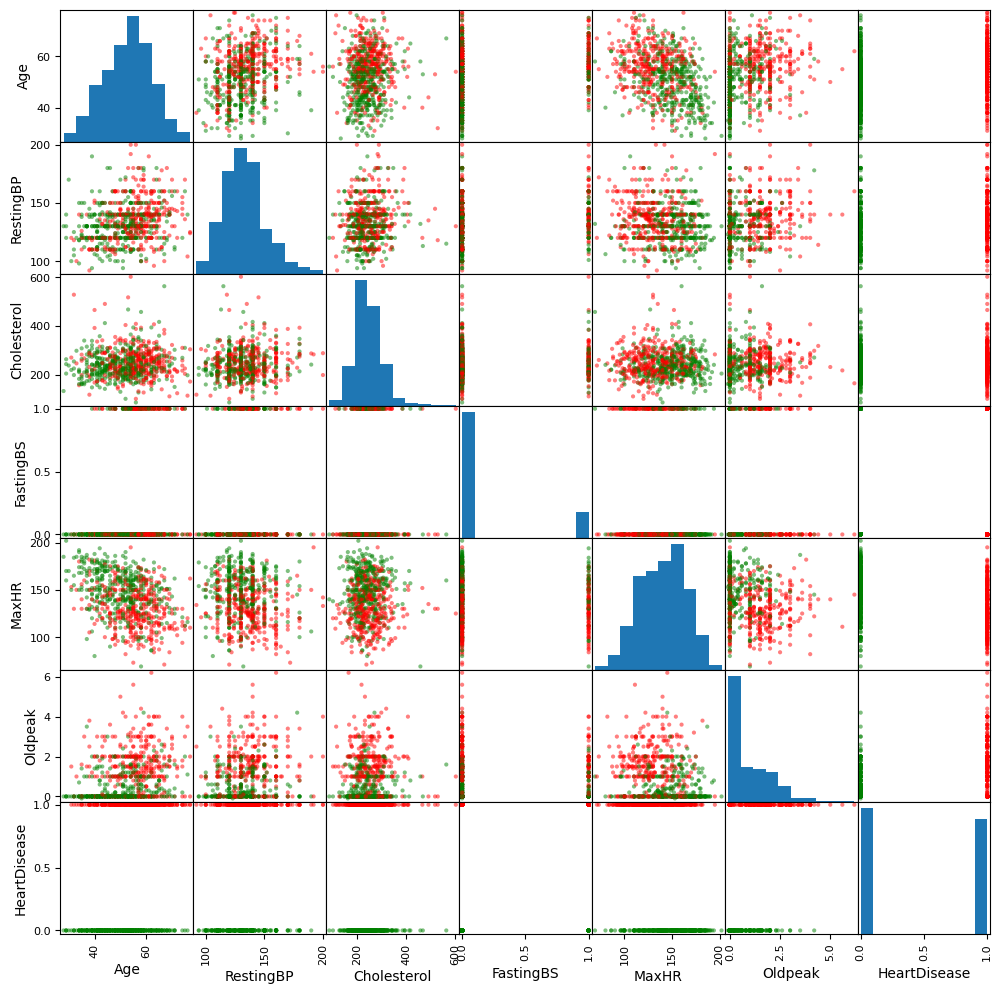

In [ ]:
from pandas.plotting import scatter_matrix
%matplotlib inline

dic_colors = { 1 : 'r', 0 : 'g'}
colors = df['HeartDisease'].map(dic_colors)

_ = scatter_matrix(df, figsize = (12, 12), diagonal = 'hist', color=colors)

### Análisis

*   **Age**: Podemos ver que las personas de la muestra tienen edades entre 28 y 77 años, aunque la mayoría superan los 46 años. Las enfermedades cardiovasculares son más frecuentes en personas de avanzada edad (correlacion de 0.29 con Heart_Disease).
*   **Resting BP**: No parece ser una varible muy importante, pero una presión en reposo muy elevada puede ser indicio de enfermedad.
*   **Cholesterol**: Altos niveles de colesterol también pueden resultar en  enfermedad.
*   **FastingBS**: Hay una ligera correlación positiva entre niveles de azúcar en la sangre y las enfermedades.
*   **MaxHR**: Nos llama la atención la notable correlación negativa (-0.377) entre MaxHR y Heart_Disease, cuanto menor sea esta, más propenso es el paciente a tener una enfermedad cardiovascular.
*   **Oldpeak**: A simple vista parece la variable más importante del archivo, tanto por la elevada correlación con Heart_Disease (0.49) como por la cantidad de puntos rojos que aparecen en el diagrama de dispersión cuando esta variable toma valores elevados.
*   **Heart_Disease**: Observamos que no se correlaciona en exceso con ninguna otra variable y que las clases 1 y 0 están distruibuidas equitativamente, como ya hemos comentado.



### 2.2) Categóricos

Analiza razonadamente las distribuciones de los valores de las variables categóricas incluyendo un diagrama de frecuencias y comentando lo más destacable.

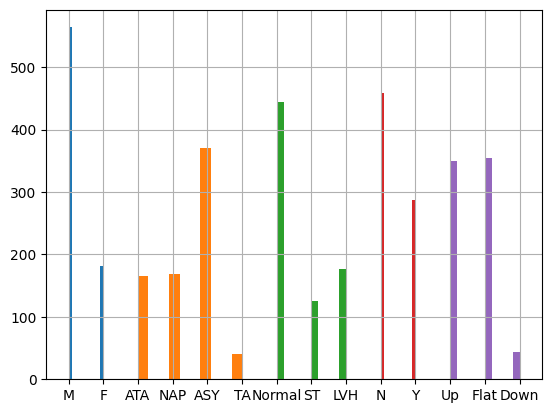

In [ ]:
_ = df['Sex'].hist()
_ = df['ChestPainType'].hist()
_ = df['RestingECG'].hist()
_ = df['ExerciseAngina'].hist()
_ = df['ST_Slope'].hist()

En cuanto a las variables categóricas, observamos que el estudio ha sido realizado principalmente a hombres. Esto puede ser un problema porque crea un desbalanceo entre los sexos, pudiendo sesgar el clasificador y reduciendo la efectividad del clasificador ante un mayor número de pacientes mujeres.

 La mayoría de los pacientes son asintomáticos (no sienten dolor de pecho), y su ECG en reposo es normal. La mayoría de los pacientes tienen un segmento ST o bien normal o bien elevado, pero muy pocos tienen depresión.

  Haremos un estudio más detenido de estas variables pasándolas a binarias mediante One Hot Encoding en los siguientes apartados.

## 3) Separa los datos en entrenamiento y test

Ajusta cada modelo de aprendizaje con los datos de entrenamiento y da una evaluación final con los datos de test.


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(['HeartDisease'], axis=1).values, df['HeartDisease'], test_size=0.3, random_state=RANDOM_STATE)
df_train = pd.DataFrame(X_train, columns=df.drop(['HeartDisease'], axis=1).columns)
df_train = df_train.join(pd.DataFrame(y_train, columns=['HeartDisease']).reset_index(drop=True))
df_test = pd.DataFrame(X_test, columns=df.drop(['HeartDisease'], axis=1).columns)
df_test = df_test.join(pd.DataFrame(y_test, columns=['HeartDisease']).reset_index(drop=True))


In [ ]:
df_train

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,67,F,ASY,106,223,0,Normal,142,N,0.3,Up,0
1,37,F,NAP,120,215,0,Normal,170,N,0.0,Up,0
2,49,M,ASY,128,212,0,Normal,96,Y,0.0,Flat,1
3,48,M,ATA,130,245,0,LVH,180,N,0.2,Flat,0
4,55,M,ASY,120,270,0,Normal,140,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
517,67,F,NAP,115,564,0,LVH,160,N,1.6,Flat,0
518,37,M,ASY,120,223,0,Normal,168,N,0.0,Up,0
519,48,M,NAP,132,220,1,ST,162,N,0.0,Flat,1
520,54,M,ASY,130,202,1,Normal,112,Y,2.0,Flat,1


In [ ]:
df_test

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,50,F,ATA,110,202,0,Normal,145,N,0.0,Up,0
1,69,M,TA,160,234,1,LVH,131,N,0.1,Flat,0
2,59,M,ASY,140,264,1,LVH,119,Y,0.0,Flat,1
3,62,M,TA,112,258,0,ST,150,Y,1.3,Flat,1
4,68,M,NAP,118,277,0,Normal,151,N,1.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
219,55,M,NAP,136,245,1,ST,131,Y,1.2,Flat,1
220,41,M,NAP,130,214,0,LVH,168,N,2.0,Flat,0
221,59,M,ASY,164,176,1,LVH,90,N,1.0,Flat,1
222,44,M,NAP,130,233,0,Normal,179,Y,0.4,Up,0


## 4) Árboles de decisión

Aplica árboles de decisión para resolver el problema.


### 4.1) Preprocesamiento de los datos

Decide si es conveniente preprocesar los datos de alguna manera. Justifica tu respuesta.

Como en este caso vamos usar árboles de decisión, no es necesario reescalar los datos. Sin embargo, sí transformaremos las variables categoricas en variables numéricas, ya sea por one hot encoding o pasar las variables a binario.

In [ ]:
o_h_encoder = OneHotEncoder()

df_numerical = df_train.drop(['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'FastingBS', 'ST_Slope', 'HeartDisease'], axis=1).copy()

df_o_h = o_h_encoder.fit_transform(df_train[['ChestPainType', 'RestingECG', 'ST_Slope']])
df_o_h = pd.DataFrame(df_o_h.toarray(), columns=o_h_encoder.get_feature_names_out(['ChestPainType', 'RestingECG', 'ST_Slope']))

df_binary = df_train[['Sex', 'FastingBS', 'ExerciseAngina', 'HeartDisease']].copy()
df_binary['Sex'] = df_binary['Sex'].apply(lambda x: 0 if x == 'M' else 1)
df_binary['ExerciseAngina'] = df_binary['ExerciseAngina'].apply(lambda x: 0 if x == 'N' else 1)

total_df_tree_train = df_numerical.join(df_o_h).join(df_binary).copy()
total_df_tree_train



,Age,RestingBP,Cholesterol,MaxHR,Oldpeak,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up,Sex,FastingBS,ExerciseAngina,HeartDisease
0,67,106,223,142,0.3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1,0,0,0
1,37,120,215,170,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1,0,0,0
2,49,128,212,96,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0,0,1,1
3,48,130,245,180,0.2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0,0,0,0
4,55,120,270,140,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
517,67,115,564,160,1.6,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1,0,0,0
518,37,120,223,168,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0,0,0,0
519,48,132,220,162,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0,1,0,1
520,54,130,202,112,2.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0,1,1,1


### 4.2) Optimizando el número mínimo de ejemplos para dividir un nodo

En este apartado vamos a entrenar nuestro clasificador e intentar dar con una parametrización que aprenda "lo justo", sin quedarse corto, ni sobreaprender.

Para ello, probaremos distintos árboles variando la profundidad máxima y usando validación cruzada en 10 partes.

Pinta las curvas de apredizaje para distintos valores de dicho parámetro en entrenamiento y validación. Analiza e interpreta las curvas (¿qué puedes decir de cómo varía el comportamiento de clasificador en entrenamiento y validación a medida que cambia el valor del parámetro?) y decide de manera razonada qué valor del parámetro es el que consideras más adecuado.

Los árboles que vas a entrenar deben utilizar la entropía como criterio de selección de variables.


Como ya hemos comentado previamente, la tasa de aciertos nos parece una medida apropiada para evaluar la profundidad óptima del árbol, ya que las clases están distribuidas equitativamente.

In [ ]:
train_accuracy = []
test_accuracy = []

# Entrenamos y validamos varios árboles con distintas profundidades máximas
max_depths = range(1, 11)
for md in max_depths:
    clf = DecisionTreeClassifier(criterion="entropy", max_depth=md, min_samples_split=2, random_state=RANDOM_STATE)
    scores = cross_validate(clf, total_df_tree_train.drop(['HeartDisease'], axis=1).values, total_df_tree_train['HeartDisease'], scoring='accuracy', cv=10, return_train_score=True)

    train_accuracy.append(np.mean(scores['train_score']))
    test_accuracy.append(np.mean(scores['test_score']))

    print("Depth:", md)
    print("     Train mean accuracy:", np.mean(scores['train_score']))
    print("     Test mean accuracy:", np.mean(scores['test_score']))

Depth: 1
     Train mean accuracy: 0.8333330308941613
     Test mean accuracy: 0.8333091436865022
Depth: 2
     Train mean accuracy: 0.8333330308941613
     Test mean accuracy: 0.8333091436865022
Depth: 3
     Train mean accuracy: 0.8812285079163453
     Test mean accuracy: 0.8603410740203193
Depth: 4
     Train mean accuracy: 0.8995322778206234
     Test mean accuracy: 0.8565674891146589
Depth: 5
     Train mean accuracy: 0.9227355623100305
     Test mean accuracy: 0.8391872278664732
Depth: 6
     Train mean accuracy: 0.9457233588894433
     Test mean accuracy: 0.8201378809869375
Depth: 7
     Train mean accuracy: 0.9667971691693508
     Test mean accuracy: 0.8296081277213352
Depth: 8
     Train mean accuracy: 0.9787170530327088
     Test mean accuracy: 0.8201378809869375
Depth: 9
     Train mean accuracy: 0.9876545842217486
     Test mean accuracy: 0.8143323657474599
Depth: 10
     Train mean accuracy: 0.9914857324320645
     Test mean accuracy: 0.8162191582002902


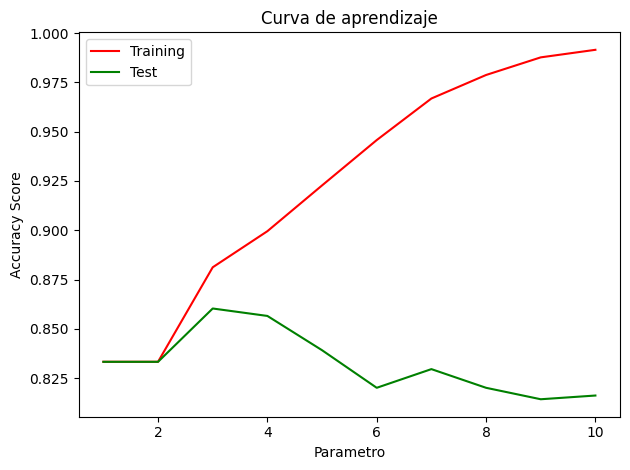

In [ ]:
# Draw lines
plt.plot(max_depths, train_accuracy, color="r",  label="Training")
plt.plot(max_depths, test_accuracy, color="g", label="Test")

# Create plot
plt.title("Curva de aprendizaje")
plt.xlabel("Parametro"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

Para max_depth=3 obtenemos el mejor valor de exactitud para el conjunto de test. A partir de esa profundidad la métrica mejora para el conjunto de entrenamiento y empeora para el conjunto de test indicando que el clasificador está sobre-entrenado y generaliza peor.

In [ ]:
# Creamos y entrenamos el árbol de decisión con los parámetros encontrados
clf = DecisionTreeClassifier(criterion="entropy", max_depth=3, min_samples_split=2, random_state=RANDOM_STATE)

# Validación cruzada dividiendo el conjunto de datos en 10 partes (folds)
scores = cross_validate(clf, total_df_tree_train.drop(['HeartDisease'], axis=1).values, total_df_tree_train['HeartDisease'], scoring='accuracy',
                        cv=10, return_train_score=True)

# scores es un diccionario con datos sobre tiempos y exactitud (accuracy)
train_accuracy = np.mean(scores['train_score'])
test_accuracy = np.mean(scores['test_score'])
print("Train mean accuracy:", train_accuracy)
print("Test mean accuracy:", test_accuracy)

Train mean accuracy: 0.8812285079163453
Test mean accuracy: 0.8603410740203193


### 4.3) Estudiando el error

Calcula la precisión, exhaustividad y valor F1 agregadas usando la profundidad óptima del árbol y validación cruzada en 10 partes. ¿Qué podemos decir sobre el funcionamiento general de nuestro clasificador?

Calcula el informe detallado para cada una de las clases y dibuja la matriz de confusión. ¿Cómo se comporta nuestro clasificador en cada una de las clases?

Finalmente, ¿cómo de fiable te parece? ¿crees que aportaría algo en una empresa real? Analiza las ventajas y desventajas de utilizar un clasificador basado en árboles de decisión en el contexto de este problema.

Primero, calculamos las métricas agregadas usando la profundidad óptima del árbol y validación cruzada en 10 partes.

In [ ]:
# Escribimos las métricas que queremos evaluar
scoring_metrics = ['precision_weighted', 'recall_weighted','f1_weighted']

# Construimos el clasificador
clf = DecisionTreeClassifier(criterion="entropy", max_depth=3, min_samples_split=2, random_state=RANDOM_STATE)

# Calculamos las métricas utilizando validación cruzada
scores = cross_validate(clf, total_df_tree_train.drop(['HeartDisease'], axis=1).values, total_df_tree_train['HeartDisease'], scoring=scoring_metrics,
                        cv=10, return_train_score=False)

# Mostrar las métricas agregadas
print('Precisión ponderada media:',np.mean(scores['test_precision_weighted']))
print('Exhaustividad ponderada media:',np.mean(scores['test_recall_weighted']))
print('F1 ponderado media:',np.mean(scores['test_f1_weighted']))

Precisión ponderada media: 0.8653268438272491
Exhaustividad ponderada media: 0.8603410740203193
F1 ponderado media: 0.8599619266189574


Observamos que las métricas indican que el 86% de las instancias clasificadas como positivas fueron realmente positivas, que el modelo identificó correctamente el 86% de todas las instancias positivas presentes en los datos,
y que el clasificador tiene un buen equilibrio entre precisión y exhaustividad.

Además, haber utilizado validación cruzada nos asegura que no hay anomalías al hacer la división entre entrenamiento y test, por lo que podemos decir que el rendimiento general del clasificador es bueno.




A continuación, calculamos las métricas detalladas por clase.

In [ ]:
# Esta función entrena 10 clasificadores usando validación cruzada y devuelve una predicción
# para cada punto usando el clasificador que no fue entrenado con ese punto
clf = DecisionTreeClassifier(criterion="entropy", max_depth=3, min_samples_split=2, random_state=RANDOM_STATE)
predictions = cross_val_predict(clf, total_df_tree_train.drop(['HeartDisease'], axis=1).values, total_df_tree_train['HeartDisease'], cv=10)

# Informe por clases
cr = classification_report(total_df_tree_train['HeartDisease'], predictions, target_names=np.array([str(x) for x in total_df_tree_train['HeartDisease'].unique()]))
print(cr)

              precision    recall  f1-score   support

           0       0.88      0.85      0.87       276
           1       0.84      0.87      0.85       246

    accuracy                           0.86       522
   macro avg       0.86      0.86      0.86       522
weighted avg       0.86      0.86      0.86       522



### Interpretación

1. **Precision**: La precisión para la clase 0 es del 88%, lo que indica que el 88% de las predicciones positivas para la ausencia de enfermedad cardiovascular son correctas. Para la clase 1, la precisión es del 84%, lo que significa que el 84% de las predicciones positivas para la presencia de enfermedad cardiovascular son correctas. En general, esto sugiere que el modelo tiene una buena capacidad para predecir tanto la presencia como la ausencia de enfermedad cardiovascular.

2. **Recall**: El recall para la clase 0 es del 85%, lo que indica que el 85% de los casos de ausencia de enfermedad cardiovascular se detectaron correctamente. Para la clase 1, el recall es del 87%, lo que significa que el 87% de los casos de presencia de enfermedad cardiovascular se detectaron correctamente. Esto sugiere que el modelo tiene una buena capacidad para detectar tanto casos positivos como negativos.

3. **F1-score**: El F1-score es la media armónica de la precisión y el recall. Para la clase 0, el F1-score es del 87%, mientras que para la clase 1 es del 85%. Estos valores equilibrados sugieren un buen rendimiento general del modelo en términos de precisión y recall.

4. **Accuracy**: La precisión general del modelo es del 86%, lo que indica que el 86% de todas las predicciones son correctas. Sin embargo, la precisión por sí sola no siempre es suficiente para evaluar un modelo, especialmente cuando las clases están desbalanceadas, como suele ser el caso en problemas médicos.

En resumen, los resultados sugieren que el modelo tiene una buena capacidad para predecir la presencia o ausencia de enfermedad cardiovascular en base a las características de los pacientes.

Mostramos la matriz de confusión.

Confusion matrix, without normalization
[[234  42]
 [ 31 215]]


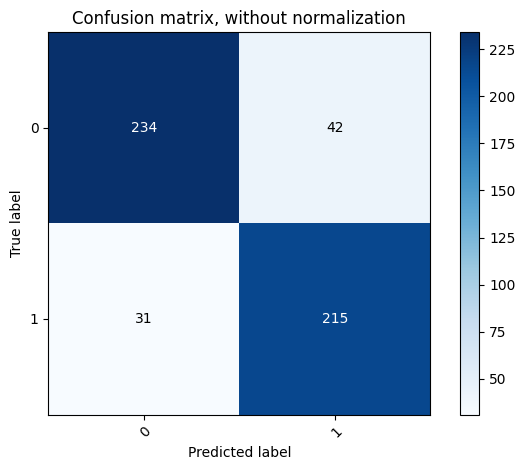

In [ ]:
# El parámetro normalize permite mostrar los porcentajes en lugar del número de instancias
_ = plot_confusion_matrix(total_df_tree_train['HeartDisease'], predictions, np.array([str(x) for x in df['HeartDisease'].unique()]), normalize=False)

Normalized confusion matrix
[[0.84782609 0.15217391]
 [0.12601626 0.87398374]]


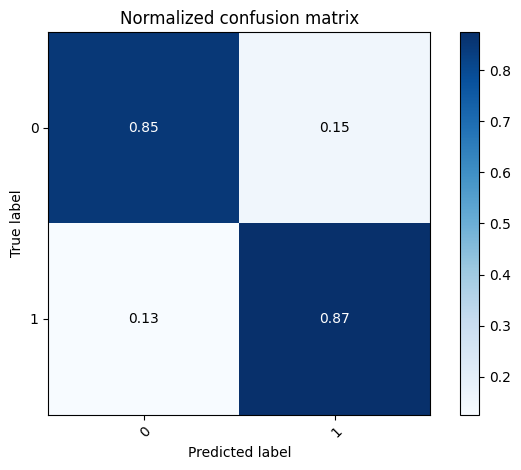

In [ ]:
_ = plot_confusion_matrix(total_df_tree_train['HeartDisease'], predictions, np.array([str(x) for x in df['HeartDisease'].unique()]), normalize=True)

La matriz de confusión está muy equilibrada, aunque hay un muy ligero sesgo del clasificador hacia la clase no enfermo (0). A pesar de haber obtenido buenos resultados en general, consideramos que un 13% de errores al predecir que un paciente no está enfermo cuando realmente sí lo está, es un porcentaje considerablemente alto de error debido a la naturaleza del problema.

Finalmente, mostramos el árbol de decisión para los mejores valores de los parámetros.

In [ ]:
clf = DecisionTreeClassifier(criterion="entropy", max_depth=3, min_samples_split=2, random_state=RANDOM_STATE)
clf = clf.fit(total_df_tree_train.drop(['HeartDisease'], axis=1).values, total_df_tree_train['HeartDisease'])

In [ ]:
# Pintamos el árbol
plt.figure(figsize=(100, 100))
plot_tree(clf, filled=True, feature_names=total_df_tree_train.drop(['HeartDisease'], axis=1).columns, class_names=np.array([str(x) for x in total_df_tree_train['HeartDisease'].unique()]), rounded=True)
plt.show()

In [ ]:
clf.feature_importances_

array([0.        , 0.05790473, 0.        , 0.01758245, 0.        ,
       0.17665442, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.67103417,
       0.02162065, 0.        , 0.05520358])

<Axes: ylabel='Importancia'>

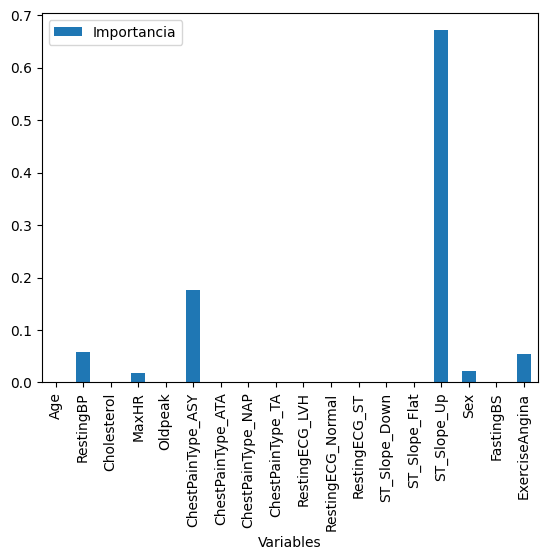

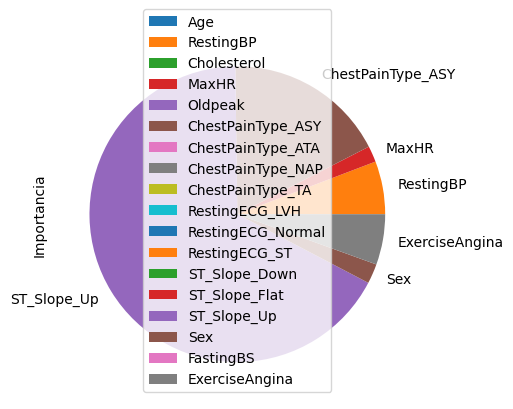

In [ ]:
importance = pd.DataFrame(data=total_df_tree_train.drop(['HeartDisease'],axis=1).columns, columns=['Variables'])
importance['Importancia'] = clf.feature_importances_
importance.plot.bar(x='Variables', y='Importancia')
importance.plot.pie(y='Importancia',labels=total_df_tree_train.drop(['HeartDisease'],axis=1).columns)

El árbol de decisión que obtenemos nos indica claramente que el mejor indicador para predecir la clase es la variable ST_Slope_Up, seguida de la variable Chest_Pain_ASY, que ya genera una gran distinción entre clases.

El caso de la primera variable resulta muy extraño a nivel médico, ya que en los casos (que son muy pocos) en los que se tiene un segmento deprimido (ST_Slope_Down), sí que hay un gran riesgo de enfermedad, pero en los casos de segmento plano (ST_Slope_Flat), no es un indicador tan directo de enfermedad cardiovascular.

Sin embargo, se están clasificando la mayoría de casos con segmento plano como enfermos, lo que puede indicar poca fiabilidad en la recogida de los datos.

Como ya hemos comprobado, el clasificador tiene un rendimiento muy alto al tratar los datos proporcionados.

Aún así, la poca fiabilidad de la recogida de datos, que hemos notado en la variable ST_Slope, y el hecho de que un clara mayoría de los pacientes del dataset sean hombres, hacen que el modelo completo tenga, en nuestra opinión, poca utlidad a la hora de diagnosticar, especialmente en un sector tan delicado como el de la salud.

Si nos centramos únicamente en el clasificador y no en el modelo completo, nuestro clasificador de árbol de decisión puede ser útil para empresas interesadas en analizar las causas de la enfermedad para hacer un estudio de mercado.

Con este modelo los datos (tanto categóricos como numéricos) se manejan con mucha facilidad, que es algo imprescindible en este caso, pudiendo incluso añadir nuevas variables sin necesidad de reescalarlas. Además, las clases se clasifican de una manera muy visual y fácil de comprender para cualquier experto.

Sin embargo, los árboles de decisión son mucho menos fiables cuando las clases no están distribuidas equitativamente. Al aumentar el dataset podría crearse un desequilibrio, lo que sesgaría el árbol hacia la clase dominante.




## 5) Resuelve el mismo problema usando un clasificador k-NN

Busca el valor óptimo para el número de vecinos

### 5.1) Preprocesamiento de los datos

En este caso si que optamos por reescalar los datos, ya que vamos a trabajar con distancias entre puntos y nos interesa que el rango de las variables sea el mismo.

In [ ]:
o_h_encoder = OneHotEncoder()

standard_scaler = StandardScaler()
df_numerical = df_train.drop(['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'FastingBS', 'ST_Slope', 'HeartDisease'], axis=1).copy()
df_numerical_values = standard_scaler.fit_transform(df_numerical)
df_numerical = pd.DataFrame(df_numerical_values, columns=list(df_numerical.columns))

df_o_h = o_h_encoder.fit_transform(df_train[['ChestPainType', 'RestingECG', 'ST_Slope']])
df_o_h = pd.DataFrame(df_o_h.toarray(), columns=o_h_encoder.get_feature_names_out(['ChestPainType', 'RestingECG', 'ST_Slope']))

df_binary = df_train[['Sex', 'FastingBS', 'ExerciseAngina', 'HeartDisease']].copy()
df_binary['Sex'] = df_binary['Sex'].apply(lambda x: 0 if x == 'M' else 1)
df_binary['ExerciseAngina'] = df_binary['ExerciseAngina'].apply(lambda x: 0 if x == 'N' else 1)

total_df_knn_train = df_numerical.join(df_o_h).join(df_binary).copy()
total_df_knn_train

,Age,RestingBP,Cholesterol,MaxHR,Oldpeak,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up,Sex,FastingBS,ExerciseAngina,HeartDisease
0,1.522804,-1.586200,-0.378130,0.138572,-0.571501,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1,0,0,0
1,-1.750200,-0.784655,-0.519169,1.293947,-0.844858,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1,0,0,0
2,-0.440999,-0.326629,-0.572058,-1.759543,-0.844858,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0,0,1,1
3,-0.550099,-0.212122,0.009727,1.706580,-0.662620,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0,0,0,0
4,0.213602,-0.784655,0.450473,0.056045,-0.844858,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
517,1.522804,-1.070921,5.633647,0.881313,0.613046,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1,0,0,0
518,-1.750200,-0.784655,-0.378130,1.211420,-0.844858,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0,0,0,0
519,-0.550099,-0.097616,-0.431019,0.963840,-0.844858,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0,1,0,1
520,0.104502,-0.212122,-0.748356,-1.099329,0.977521,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0,1,1,1


### 5.2) Optimizando el número de vecinos más cercanos

De nuevo utilizaremos la tasa de aciertos para evaluar cúal es el número óptimo de vecinos.

Variaremos el parámetro k desde 1 hasta 37, que conforma aproximadamente el 7% de los datos.

In [ ]:
# Medias y desviaciones típicas de accuracy para distintos valores de k
accuracy_mean = []
accuracy_std = []

k_values = range(1,37)
for k in k_values:
    # Entrenar y validar
    clf = KNeighborsClassifier(k, weights='distance')
    scores = cross_validate(clf, total_df_knn_train.drop(['HeartDisease'], axis=1).values, total_df_knn_train['HeartDisease'], scoring='accuracy', cv=10)

    accuracy_mean.append(np.mean(scores['test_score']))
    accuracy_std.append(np.std(scores['test_score']))
    print("K:", k)
    print("     Test mean accuracy:", np.mean(scores['test_score']))
    print("     Test accuracy std:", np.std(scores['test_score']))

K: 1
     Test mean accuracy: 0.8179245283018867
     Test accuracy std: 0.0617228168680129
K: 2
     Test mean accuracy: 0.8179245283018867
     Test accuracy std: 0.0617228168680129
K: 3
     Test mean accuracy: 0.8544267053701015
     Test accuracy std: 0.062053191393374715
K: 4
     Test mean accuracy: 0.8563860667634252
     Test accuracy std: 0.05569655545722457
K: 5
     Test mean accuracy: 0.8411465892597967
     Test accuracy std: 0.0664794078724062
K: 6
     Test mean accuracy: 0.8487663280116111
     Test accuracy std: 0.056177875605491846
K: 7
     Test mean accuracy: 0.8621552975326561
     Test accuracy std: 0.04735573773683944
K: 8
     Test mean accuracy: 0.8659651669085632
     Test accuracy std: 0.04916383707611921
K: 9
     Test mean accuracy: 0.8601959361393325
     Test accuracy std: 0.04616948975420619
K: 10
     Test mean accuracy: 0.8563497822931787
     Test accuracy std: 0.050937878310487184
K: 11
     Test mean accuracy: 0.8583091436865024
     Test accuracy 

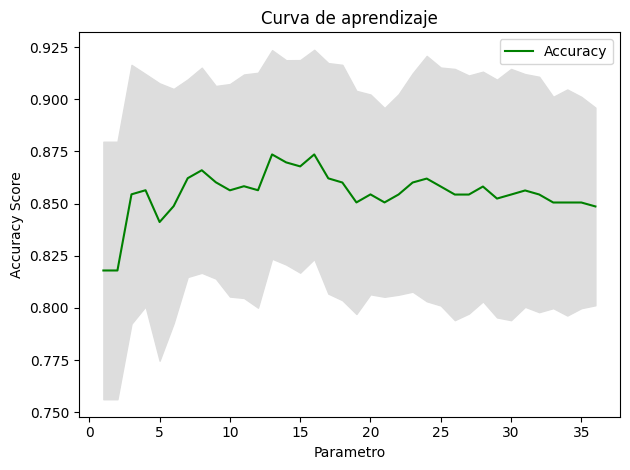

In [ ]:
# Dibujamos la línea con la accuracy (exactitud) en el test
plt.plot(k_values, accuracy_mean, color="g", label="Accuracy")

# Dibujamos la banda de la desviación típica
lower_limit = np.array(accuracy_mean) - np.array(accuracy_std)
upper_limit = np.array(accuracy_mean) + np.array(accuracy_std)
plt.fill_between(k_values, lower_limit, upper_limit, color="#DDDDDD")

# Creamos el gráfico
plt.title("Curva de aprendizaje")
plt.xlabel("Parametro"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

Para K=16 obtenemos el mejor valor de exactitud para el conjunto de test. A partir de ese número de vecinos más cercanos la métrica empeora para el conjunto de test indicando que el clasificador está sobre-entrenado y generaliza peor.

In [ ]:
# Creamos y entrenamos el clasificador k-NN con los parámetros encontrados
clf = KNeighborsClassifier(n_neighbors=16, weights='distance')

# Validación cruzada dividiendo el conjunto de datos en 10 partes (folds)
scores = cross_validate(clf, total_df_knn_train.drop(['HeartDisease'], axis=1).values, total_df_knn_train['HeartDisease'], scoring='accuracy',cv=10, return_train_score=False)

print('Accuracy mean:', np.mean(scores['test_score']))
print('Accuracy std:', np.std(scores['test_score']))

Accuracy mean: 0.8735486211901307
Accuracy std: 0.05014987669244226


### 5.3) Estudiando el error

Primero, calculamos las métricas agregadas usando el número óptimo de vecinos y validación cruzada en 10 partes.

In [ ]:
scoring_metrics = ['precision_weighted', 'recall_weighted','f1_weighted']

# Los mejores resultados se obtenían para k=10 sobre los datos re-escalados
clf = KNeighborsClassifier(16, weights='distance')

# Calculamos las métricas sobre los datos escalados utilizando validación cruzada
scores = cross_validate(clf, total_df_knn_train.drop(['HeartDisease'], axis=1).values, total_df_knn_train['HeartDisease'], scoring=scoring_metrics, cv=10, return_train_score=False)

print('Precisión ponderada media:',np.mean(scores['test_precision_weighted']))
print('Exhaustividad ponderada media:',np.mean(scores['test_recall_weighted']))
print('F1 ponderado media:',np.mean(scores['test_f1_weighted']))

Precisión ponderada media: 0.8767681767082915
Exhaustividad ponderada media: 0.8735486211901307
F1 ponderado media: 0.8733511014443905


Observamos que, en rasgos generales, el clasificador tiene un rendimiento muy bueno, superando al de árbol de decisión en todas las métricas, es decir, se ajusta mejor al conjunto de entrenamiento. Además, al trabajar con validación cruzada nos aseguramos que la distribución de los datos de entrenamiento y test no es una anomalía.

A continuación, calculamos las métricas detalladas por clase.

In [ ]:
# Esta función entrena 10 clasificadores usando validación cruzada y devuelve una predicción
# para cada punto usando el clasificador que no fue entrenado con ese punto
clf = KNeighborsClassifier(16, weights='distance')
predictions = cross_val_predict(clf, total_df_knn_train.drop(['HeartDisease'], axis=1).values, total_df_knn_train['HeartDisease'], cv=10)

# Informe por clases
cr = classification_report(total_df_knn_train['HeartDisease'], predictions, target_names=np.array([str(x) for x in total_df_knn_train['HeartDisease'].unique()]))
print(cr)

              precision    recall  f1-score   support

           0       0.89      0.87      0.88       276
           1       0.86      0.88      0.87       246

    accuracy                           0.87       522
   macro avg       0.87      0.87      0.87       522
weighted avg       0.87      0.87      0.87       522



De nuevo nos encontramos que el modelo responde muy bien ante individuos de ambas clases, clasificando un poco mejor a los individuos que no padecen enfermedad, que son un poco más abundantes en el conjunto de datos. El mismo razonamiento hecho para el árbol de decisión aplica a estos valores.

Finalmente, mostramos la matriz de confusión.

Confusion matrix, without normalization
[[240  36]
 [ 30 216]]


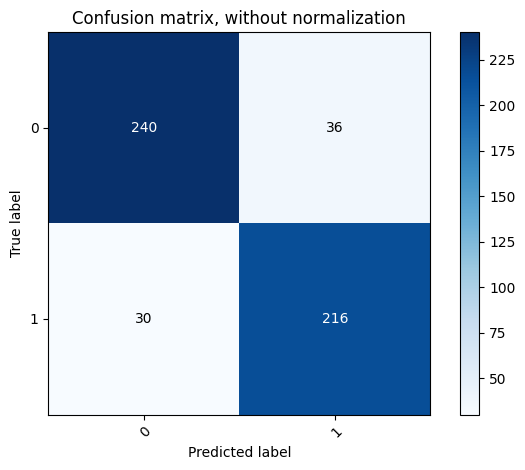

In [ ]:
_ = plot_confusion_matrix(total_df_knn_train['HeartDisease'], predictions, np.array([str(x) for x in total_df_knn_train['HeartDisease'].unique()]), normalize=False)

Normalized confusion matrix
[[0.86956522 0.13043478]
 [0.12195122 0.87804878]]


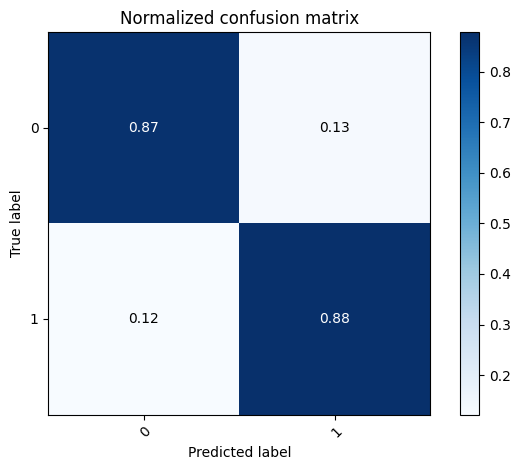

In [ ]:
_ = plot_confusion_matrix(total_df_knn_train['HeartDisease'], predictions, np.array([str(x) for x in df['HeartDisease'].unique()]), normalize=True)

Las matrices de confusión nos indican que el rendimiento del clasificador es bueno, mejor incluso que el de árbol de decisión.

De nuevo ignorando los problemas en la captación de datos que ya hemos analizado en el clasificador de árbol de decisión y que hacen poco práctico el modelo, nos centraremos únicamente en el clasificador.

El clasificador tiene un rendimiento a priori muy bueno, ligeramente mejor que los árboles de decisión. Sin embargo, teniendo en cuenta de nuevo la extremada sensibilidad del problema, que los individuos afectados se diagnostiquen un 88% de las veces es un porcentaje algo insuficiente.

Otra desventaja es que el clasificador KNN es muy susceptible al aumento de variables del problema, especialmente a variables irrelevantes.

A diferencia de los árboles de decisión, los resultados del clasificador KNN, aunque son sencillos de computar, no son fáciles de interpretar visualmente ni de adaptar a más variables, por lo que en este caso no le vemos tanta utilidad como nuestro clasificador de árbol para las empresas.



## 6) Resuelve el mismo problema usando un clasificador MLP

Optimiza el coeficiente de regularización


### 6.1) Preprocesamiento de los datos

En este caso también optamos por reescalar los datos, como ya tenemos las variables categóricas pasadas a binarias y los datos estandarizados en el data frame que contruimos para el clasificador Knn, solamente la pasamos a otro dataframe para el clasificador MLP. Los clasificadores MLP pueden tratar con vaariables sin escalar, pero al hacerlo reducimos tanto el tiempo de entrenamiento como el riesgo de sobreajuste del modelo.

In [ ]:
total_df_mlp_train = total_df_knn_train.copy()
total_df_mlp_train

,Age,RestingBP,Cholesterol,MaxHR,Oldpeak,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up,Sex,FastingBS,ExerciseAngina,HeartDisease
0,1.522804,-1.586200,-0.378130,0.138572,-0.571501,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1,0,0,0
1,-1.750200,-0.784655,-0.519169,1.293947,-0.844858,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1,0,0,0
2,-0.440999,-0.326629,-0.572058,-1.759543,-0.844858,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0,0,1,1
3,-0.550099,-0.212122,0.009727,1.706580,-0.662620,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0,0,0,0
4,0.213602,-0.784655,0.450473,0.056045,-0.844858,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
517,1.522804,-1.070921,5.633647,0.881313,0.613046,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1,0,0,0
518,-1.750200,-0.784655,-0.378130,1.211420,-0.844858,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0,0,0,0
519,-0.550099,-0.097616,-0.431019,0.963840,-0.844858,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0,1,0,1
520,0.104502,-0.212122,-0.748356,-1.099329,0.977521,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0,1,1,1


### 6.2) Optimizando el número mínimo de ejemplos para dividir un nodo

De todos los parámetros que podemos configurar en la red neuronal (capas, neuronas, funciones de activación, regulación, tasa de aprendizaje, ...) nosotros sólo vamos optimizar el coeficiente de regularización.

Vamos a explorar una red con una capa oculta con 100 neuronas, función de activación ReLU, tamaño de mini-batch 100, tasa de aprendizaje 0.001, y máximo de 2000 iteraciones a los datos (epochs).

Utilizaremos validación cruzada con N = 10 para optimizar el coeficiente de regularización en el rango [0, 2].

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_validate
import numpy as np

accuracy_mean = []
accuracy_std = []

# Entrenar y validar distintas configuraciones
regul_param_range = np.arange(0, 2.1, step=0.1) # [0.1, 0.2, ... 2]
for regul_param in regul_param_range:
    # Aumentamos el parámetro max_iter hasta que converja
    clf = MLPClassifier(hidden_layer_sizes=(100, ), activation='relu', solver='adam', alpha=regul_param, batch_size=100,
             learning_rate_init=0.001, max_iter=2000, random_state=RANDOM_STATE)

    scores = cross_validate(clf, total_df_mlp_train.drop(['HeartDisease'], axis=1).values, total_df_mlp_train['HeartDisease'], scoring='accuracy', cv=10)

    accuracy_mean.append(np.mean(scores['test_score']))
    accuracy_std.append(np.std(scores['test_score']))
    print("Coeficiente de regularización:", regul_param)
    print("     Test mean accuracy:", np.mean(scores['test_score']))
    print("     Test accuracy std:", np.std(scores['test_score']))

Coeficiente de regularización: 0.0
     Test mean accuracy: 0.844956458635704
     Test accuracy std: 0.06629740689664192
Coeficiente de regularización: 0.1
     Test mean accuracy: 0.8487663280116111
     Test accuracy std: 0.05431987580493479
Coeficiente de regularización: 0.2
     Test mean accuracy: 0.8565312046444122
     Test accuracy std: 0.05838264848370562
Coeficiente de regularización: 0.30000000000000004
     Test mean accuracy: 0.8603047895500726
     Test accuracy std: 0.05174679419244738
Coeficiente de regularización: 0.4
     Test mean accuracy: 0.8678519593613933
     Test accuracy std: 0.043247313810403164
Coeficiente de regularización: 0.5
     Test mean accuracy: 0.8639695210449927
     Test accuracy std: 0.04670375147948319
Coeficiente de regularización: 0.6000000000000001
     Test mean accuracy: 0.8697750362844701
     Test accuracy std: 0.04436314785945062
Coeficiente de regularización: 0.7000000000000001
     Test mean accuracy: 0.8679245283018868
     Test accu

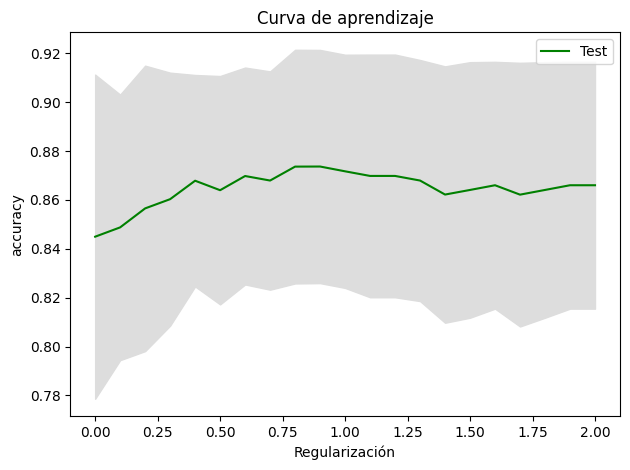

In [ ]:
import matplotlib.pyplot as plt

# Dibujamos la línea de la exactitud media en las partes de test
plt.plot(regul_param_range, accuracy_mean, color="g", label="Test")

# Dibujamos la banda de la desviación típica
lower_limit = np.array(accuracy_mean) - np.array(accuracy_std)
upper_limit = np.array(accuracy_mean) + np.array(accuracy_std)
plt.fill_between(regul_param_range, lower_limit, upper_limit, color="#DDDDDD")

# Creamos el gráfico
plt.title("Curva de aprendizaje")
plt.xlabel("Regularización"), plt.ylabel("accuracy"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

Observamos que el valor óptimo del coeficiente es alpha = 0.9.

Si alpha < 0.9, la penalización aplicada a los pesos de la red es menor, lo que permite que el modelo tenga una mayor libertad para ajustarse a los datos de entrenamiento y por tanto el modelo sobreaprende.

Si alpha > 0.9, se aplica una penalización más fuerte a los pesos de la red, lo que hace que el modelo prefiera soluciones más simples que minimicen la magnitud de los pesos, generando así un subajuste.

Exactitud de nuestro clasificador MLP:

In [ ]:
# Creamos el clasificador MLP con los parámetros encontrados
clf = MLPClassifier(hidden_layer_sizes=(100, ), activation='relu', solver='adam', alpha=0.9, batch_size=100,
             learning_rate_init=0.001, max_iter=2000, random_state=RANDOM_STATE)

# Validación cruzada dividiendo el conjunto de datos en 10 partes (folds)
scores = cross_validate(clf, total_df_mlp_train.drop(['HeartDisease'], axis=1).values, total_df_mlp_train['HeartDisease'], scoring='accuracy',cv=10, return_train_score=False)

print('Accuracy mean:', np.mean(scores['test_score']))
print('Accuracy std:', np.std(scores['test_score']))


Accuracy mean: 0.8736574746008708
Accuracy std: 0.04769711961393213


### 6.3) Estudiando el error

Primero, calculamos las métricas agregadas usando el coeficiente de regularización óptimo y validación cruzada en 10 partes.

In [ ]:
scoring_metrics = ['precision_weighted', 'recall_weighted','f1_weighted']

# Los mejores resultados se obtenían para alpha=0.9 sobre los datos re-escalados
clf = MLPClassifier(hidden_layer_sizes=(100, ), activation='relu', solver='adam', alpha=0.9, batch_size=100,
             learning_rate_init=0.001, max_iter=2000, random_state=333)

# Calculamos las métricas sobre los datos escalados utilizando validación cruzada
scores = cross_validate(clf, total_df_mlp_train.drop(['HeartDisease'], axis=1).values,
                        total_df_mlp_train['HeartDisease'], scoring=scoring_metrics, cv=10, return_train_score=False)

print('Precisión ponderada media:',np.mean(scores['test_precision_weighted']))
print('Exhaustividad ponderada media:',np.mean(scores['test_recall_weighted']))
print('F1 ponderado media:',np.mean(scores['test_f1_weighted']))

Precisión ponderada media: 0.8782882218584552
Exhaustividad ponderada media: 0.8736574746008708
F1 ponderado media: 0.87331420960122


Observamos que, en rasgos generales, el clasificador tiene un rendimiento muy bueno, superando al árbol de decisión y ligeramente al kNN en todas las métricas. Además, al trabajar con validación cruzada nos aseguramos que la distribución de los datos de entrenamiento y test no es una anomalía.

Métricas por clases:

In [ ]:
clf = MLPClassifier(hidden_layer_sizes=(100, ), activation='relu', solver='adam', alpha=0.9, batch_size=100,
             learning_rate_init=0.001, max_iter=2000, random_state=RANDOM_STATE)
predictions = cross_val_predict(clf, total_df_mlp_train.drop(['HeartDisease'], axis=1).values, total_df_mlp_train['HeartDisease'], cv=10)

# Informe por clases
cr = classification_report(total_df_mlp_train['HeartDisease'], predictions, target_names=np.array([str(x) for x in total_df_mlp_train['HeartDisease'].unique()]))
print(cr)

              precision    recall  f1-score   support

           0       0.89      0.87      0.88       276
           1       0.86      0.88      0.87       246

    accuracy                           0.87       522
   macro avg       0.87      0.87      0.87       522
weighted avg       0.87      0.87      0.87       522



De nuevo nos encontramos que el modelo responde muy bien ante individuos de ambas clases, clasificando un poco mejor a los individuos que no padecen enfermedad, que son un poco más abundantes en el conjunto de datos.
Podemos apreciar que el recall de la clase 1, es decir, de los pacientes que están enfermos, ha aumentado. Esto significa que el modelo ha predicho correctamente a un número mayor de enfermos. Además, la medida f1 es mayor que en los otros modelos.

Matriz de confusión:

Confusion matrix, without normalization
[[240  36]
 [ 30 216]]


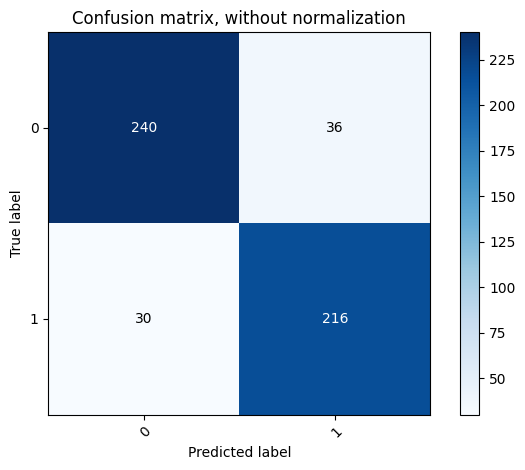

In [ ]:
_ = plot_confusion_matrix(total_df_mlp_train['HeartDisease'], predictions, np.array([str(x) for x in total_df_mlp_train['HeartDisease'].unique()]), normalize=False)

Normalized confusion matrix
[[0.86956522 0.13043478]
 [0.12195122 0.87804878]]


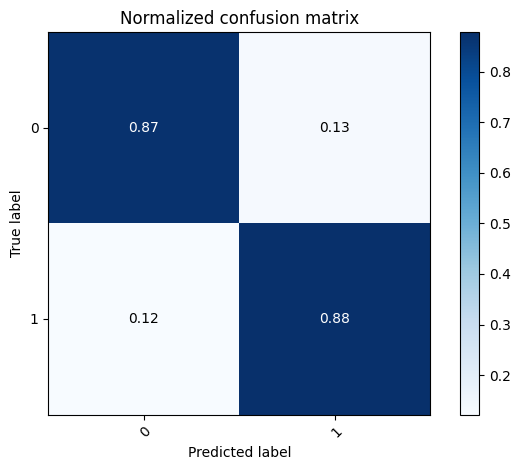

In [ ]:
_ = plot_confusion_matrix(total_df_mlp_train['HeartDisease'], predictions, np.array([str(x) for x in df['HeartDisease'].unique()]), normalize=True)

Las matrices de confusión nos indican que el rendimiento del clasificador es bueno.

De nuevo ignorando los problemas en la captación de datos que ya hemos analizado, nos centraremos únicamente en el clasificador.

El clasificador tiene un rendimiento muy bueno, muy similar al obtenido por kNN. Sin embargo, teniendo en cuenta de nuevo la extremada sensibilidad del problema, que los individuos afectados se diagnostiquen un 88% de las veces es un porcentaje algo insuficiente.

A diferencia de los árboles de decisión, los resultados del clasificador MLP no son fáciles de interpretar visualmente ni de adaptar a más variables, igual que sucedía con el kNN. Además, es mucho más complejo computacionalmente.

El rendimiento de este algoritmo podría mejorar mucho si se optimizaran el resto de parámetros, pero el coste computacional de hacer esa exploración sería mucho más grande.

## 7) Comparación de resultados

Muestra los resultados en test de los mejores modelos.
Discute cual es el mejor.

Primero reescalamos los datos a la misma escala que están reescalados los datos correspondientes al conjunto de entrenamiento.

In [ ]:
df_numerical_test = df_test.drop(['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'FastingBS', 'ST_Slope', 'HeartDisease'], axis=1).copy()
df_numerical_test_scaled = standard_scaler.transform(df_numerical_test)
df_numerical_test_scaled = pd.DataFrame(df_numerical_test_scaled, columns=list(df_numerical_test.columns))

df_o_h_test = o_h_encoder.transform(df_test[['ChestPainType', 'RestingECG', 'ST_Slope']])
df_o_h_test = pd.DataFrame(df_o_h_test.toarray(), columns=o_h_encoder.get_feature_names_out(['ChestPainType', 'RestingECG', 'ST_Slope']))

df_binary_test = df_test[['Sex', 'FastingBS', 'ExerciseAngina', 'HeartDisease']].copy()
df_binary_test['Sex'] = df_binary_test['Sex'].apply(lambda x: 0 if x == 'M' else 1)
df_binary_test['ExerciseAngina'] = df_binary_test['ExerciseAngina'].apply(lambda x: 0 if x == 'N' else 1)

In [ ]:
# Para el árbol de decision no escalamos, igual que para el conjunto de test
total_df_tree_test = df_numerical_test.join(df_o_h_test).join(df_binary_test).copy()

In [ ]:
# Para knn y mlp si que escalamos
total_df_knn_test = df_numerical_test_scaled.join(df_o_h_test).join(df_binary_test).copy()

In [ ]:
total_df_mlp_test = total_df_knn_test.copy()

In [ ]:
clf = DecisionTreeClassifier(criterion="entropy", max_depth=3, min_samples_split=2, random_state=RANDOM_STATE)
clf = clf.fit(total_df_tree_train.drop(['HeartDisease'], axis=1).values, total_df_tree_train['HeartDisease'])

# Calculamos la precisión del modelo de entrenamiento y de test
train_accuracy_tree = clf.score(total_df_tree_train.drop(['HeartDisease'], axis=1).values, total_df_tree_train['HeartDisease'])
test_accuracy_tree = clf.score(total_df_tree_test.drop(['HeartDisease'], axis=1).values, total_df_tree_test['HeartDisease'])

predictions_tree = clf.predict(total_df_tree_test.drop(['HeartDisease'], axis=1).values)

In [ ]:
clf = KNeighborsClassifier(n_neighbors=16, weights='distance')
clf = clf.fit(total_df_knn_train.drop(['HeartDisease'], axis=1).values, total_df_knn_train['HeartDisease'])

# Calculamos la precisión del modelo de entrenamiento y de test
train_accuracy_knn = clf.score(total_df_knn_train.drop(['HeartDisease'], axis=1).values, total_df_knn_train['HeartDisease'])
test_accuracy_knn = clf.score(total_df_knn_test.drop(['HeartDisease'], axis=1).values, total_df_knn_test['HeartDisease'])

predictions_knn = clf.predict(total_df_knn_test.drop(['HeartDisease'], axis=1).values)

In [ ]:
clf = MLPClassifier(hidden_layer_sizes=(100, ), activation='relu', solver='adam', alpha=0.9, batch_size=100,
             learning_rate_init=0.001, max_iter=2000, random_state=RANDOM_STATE)
clf.fit(total_df_mlp_train.drop(['HeartDisease'], axis=1).values, total_df_mlp_train['HeartDisease'])

# Calculamos la precisión del modelo de entrenamiento y de test
train_accuracy_mlp = clf.score(total_df_mlp_train.drop(['HeartDisease'], axis=1).values, total_df_mlp_train['HeartDisease'])
test_accuracy_mlp = clf.score(total_df_mlp_test.drop(['HeartDisease'], axis=1).values, total_df_mlp_test['HeartDisease'])

predictions_mlp = clf.predict(total_df_mlp_test.drop(['HeartDisease'], axis=1).values)

In [ ]:
print("Decision Tree Clasifier:")
print("     Train accuracy:", train_accuracy_tree)
print("     Test accuracy:", test_accuracy_tree)

print("\nkNN Clasifier:")
print("     Train accuracy:", train_accuracy_knn)
print("     Test accuracy:", test_accuracy_knn)

print("\nMLP Clasifier:")
print("     Train accuracy:", train_accuracy_mlp)
print("     Test accuracy:", test_accuracy_mlp)

Decision Tree Clasifier:
     Train accuracy: 0.8831417624521073
     Test accuracy: 0.7946428571428571

kNN Clasifier:
     Train accuracy: 1.0
     Test accuracy: 0.8214285714285714

MLP Clasifier:
     Train accuracy: 0.8908045977011494
     Test accuracy: 0.8303571428571429


Tras entrenar nuestros clasificadores con los parámetros optimizados en el conjunto de entrenamiento, hemos predicho si los pacientes del conjunto de test sufren una enfermedad cardíaca o no. Hemos obtenido los valores de la celda de arriba. En ellos, podemos ver cómo el clasificador por árbol de decisión es el que ha acertado un menor porcentaje, lo que sugiere que cuando recibe datos a los que nunca se ha enfrentado, no es capaz de hacer una predicción tan buena como los otros dos clasificadores. El clasificador kNN ha predecido correctamente el 82% de los datos y el MLP un 83%, que es un rendimiento bastante bueno.

Sin embargo, hay que analizar también cuántos pacientes que padecen una enfermedad han sido predichos incorrectamente, pues este un fallo muy importante a tener en cuenta debido a la sensibilidad del problema. Esto lo veremos en las matrices de confusión de a continuación.

Decision Tree Clasifier Confusion Matrix

Confusion matrix, without normalization
[[92 22]
 [24 86]]
Normalized confusion matrix
[[0.80701754 0.19298246]
 [0.21818182 0.78181818]]


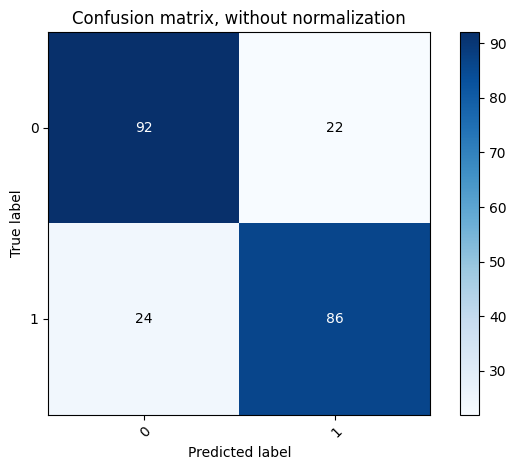

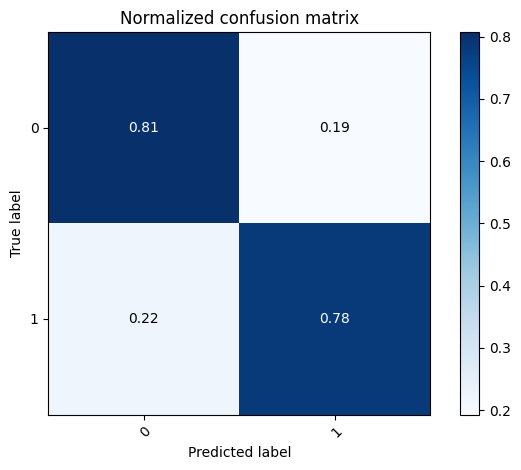

In [ ]:
print("Decision Tree Clasifier Confusion Matrix\n")
_ = plot_confusion_matrix(total_df_tree_test['HeartDisease'], predictions_tree, np.array([str(x) for x in df['HeartDisease'].unique()]), normalize=False)
_ = plot_confusion_matrix(total_df_tree_test['HeartDisease'], predictions_tree, np.array([str(x) for x in df['HeartDisease'].unique()]), normalize=True)


Como vemos en las matrices de confusión, el rendimiento del clasificador sobre el conjunto de test ha bajado considerablemente.

Es especialmente alarmante que solo un 78% de las personas enfermas fueron clasificadas como tal, lo que indica que el clasificador no rinde al nivel necesario en un sector tan delicado como la salud.

Sin embargo, como ya comentamos previamente, si el objetivo del modelo no es diagnosticar esta enfermedad si no utilizarlo para campos menos sensibles por alguna empresa farmacéutica o para ciertos profesionales de la salud, este modelo puede ser útil por su fácil interpretabilidad.



kNN Clasifier Confusion Matrix

Confusion matrix, without normalization
[[100  14]
 [ 26  84]]
Normalized confusion matrix
[[0.87719298 0.12280702]
 [0.23636364 0.76363636]]


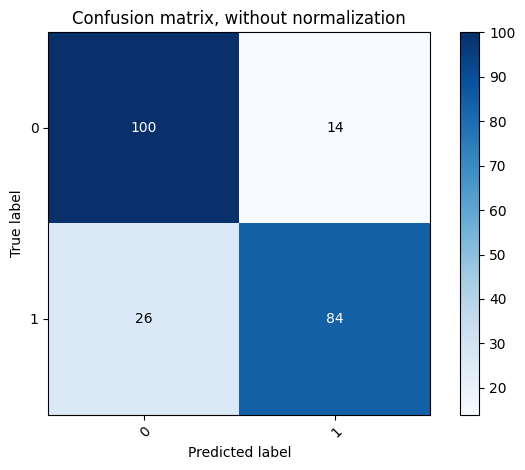

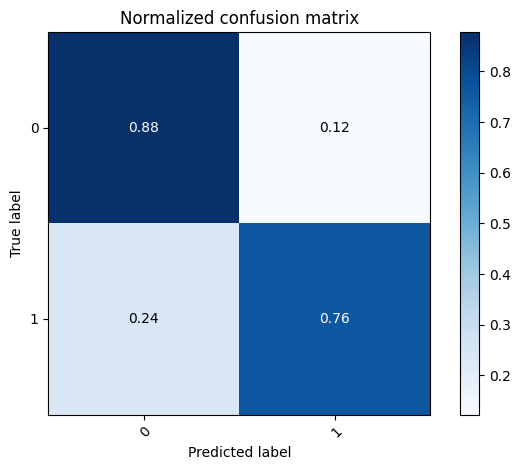

In [ ]:
print("kNN Clasifier Confusion Matrix\n")
_ = plot_confusion_matrix(total_df_knn_test['HeartDisease'], predictions_knn, np.array([str(x) for x in df['HeartDisease'].unique()]), normalize=False)
_ = plot_confusion_matrix(total_df_knn_test['HeartDisease'], predictions_knn, np.array([str(x) for x in df['HeartDisease'].unique()]), normalize=True)

En el caso de knn, a pesar de que la precisión del algoritmo es de un 82%, que no empeora tanto como la de los árboles de decisión, vemos que identifica solo a un 76% de los enfermos de enfermedad cardiovascular, que no es una cifra aceptable para este sector.

A pesar de que es un clasificador muy poco costoso computacionalmente, no le vemos gran utilidad a nivel profesional como sí que le vemos a nuestro clasificador de árbol de decisión más allá de comparar los resultados con un modelo más complejo y menos explicable.

MLP Clasifier Confusion Matrix

Confusion matrix, without normalization
[[99 15]
 [23 87]]
Normalized confusion matrix
[[0.86842105 0.13157895]
 [0.20909091 0.79090909]]


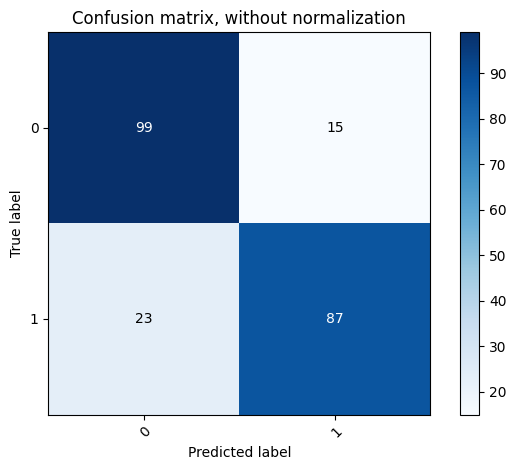

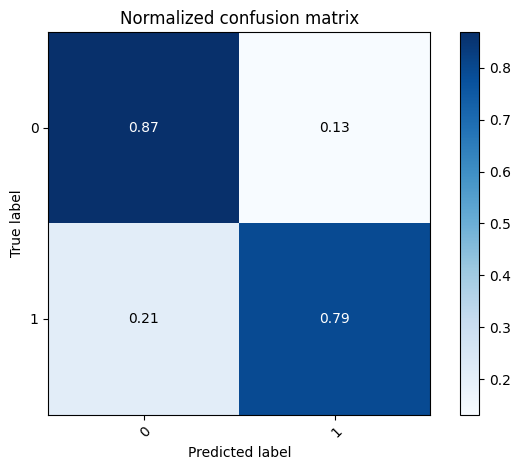

In [ ]:
print("MLP Clasifier Confusion Matrix\n")
_ = plot_confusion_matrix(total_df_mlp_test['HeartDisease'], predictions_mlp, np.array([str(x) for x in df['HeartDisease'].unique()]), normalize=False)
_ = plot_confusion_matrix(total_df_mlp_test['HeartDisease'], predictions_mlp, np.array([str(x) for x in df['HeartDisease'].unique()]), normalize=True)


El clasificador mlp es el que mejor se comporta con los datos de test, alcanzando un 83% de tasa de aciertos y siendo mejor diagnosticando a los enfermos, a un 79% de ellos.

Estos resultados, aunque mejores, son insuficientes para el sector. Además, este modelo es tanto difícil de explicar como costoso computacionalente, lo que lo hace también bastante poco útil.

Si se hubieran realizado una optimización de más parámetros de este clasificado, este podría ser aún más potente. Esto requeriría un coste computacional mucho mayor, sin una garantía de mejorar los resultados lo suficiente.

**CONCLUSIÓN**:

De los tres clasificadores que hemos estudiado consideramos que el más útil es el de árbol de decisión por su fácil explicabilidad y poco coste computacional.

Si se nos hubiera planteado este problema en la realidad y a mayor escala, probablemente lo hubiéramos enfrentado con algún clasificador que minimice el riesgo de overfitting, como puede ser un algoritmo de random forest, sobretodo si nuestro dataset fuera más grande, con más variables y menos equilibrado entre las clases.